<a href="https://colab.research.google.com/github/radu-dumitru/makemore_mlp/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-01-15 10:28:01--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.11’

names.txt.11        100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-01-15 10:28:02 (5.60 MB/s) - ‘names.txt.11’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# throughout the code there are comments about being 32 examples. We didn't processed all the names initially, only the first 5 and that's were the 32 examples come from.
# it is easier to understand what the code does when there are only 32 examples instead of thousands of examples

block_size = 3 # context length: how many characters do we take to predict the next one?


# training split (train the parameters), dev/validation split (train the hyperparameters), test split (evaluate the performance of the model)
# 80% 10% 10%
def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
C = torch.randn((27, 2), generator=g) # we have 27 possible characters and we embed each character in an vector with 2 dimensions (27 rows and 2 columns)

# we want to create the hidden layer
# the number of inputs = 6 because we have 2 dimensional embeddings (each word is a vector with 2 dimensions) and we have 3 of them
# the number of neurons is a hyperparameter and we set it to 100
# we have 100 neurons and each neuron has 6 inputs (3 words and each word is an array with 2 dimensions)
W1 = torch.randn((6, 100), generator=g)
# biases
b1 = torch.randn(100, generator=g)

# the output layer
# there are 27 possible characters
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
# learning rate exponent
#lre = torch.linspace(-3, 0, 1000)
#lrs = 10**lre

#lri = []
#lossi = []

for i in range(1000):

  # minibatch construct
  # generate 32 integers between 0 and the number of examples that we will use to index into the dataset (the batch size is 32)
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # how do we simultaneously embed all of the 32 x 3 integers stored in the array X?
  # for each element in X (which is an array of 3 values) you want the corresponding 2 dimensional array from C => 32 values, each value is an array of 3 elements and each element is an array with 2 numbers

  # X is an array of 32 elements and each element is another array with 3 values
  # C[X] - this will create an array with 32 elements
  #      - each element is an array with 3 values because X contains elements with 3 values
  #      - each value is an array with 2 other values because C is an array with 37 elements and each element has 2 values
  #      - the shape of C[X] is [32, 3, 2]

  emb = C[Xtr][ix] # only grab the minibatch rows

  # we want: emb @ W1 + b1 but this will not work due to the differences in the shape of emb and W1
  # we need to transform emb which is 32 x 3 x 2 into 32 x 6

  h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
  # why is h.shape 32 x 100?
  # there are 32 examples, each example has a context length of 3, 3 words, each word is represented through a 2D vector => each example contains 6 numbers
  # there are 100 neurons. For each neuron you want to multiply each of the 6 numbers with a weight, add the bias and apply tanh and you want to do this for all the 32 examples
  # so in the end you will have an matrix with 32 rows due to the 32 examples and each row has 100 values, each value represents the output of each of the 100 neurons

  logits = h @ W2 + b2
  # logits.shape = 32 x 27 => there are 32 examples and 27 possible characters for each example

  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims = True)
  # we would like to index into the rows of prob and from each row we would like to get the probability assigned to the correct character (we have the correct character in Y)
  # loss = -prob[torch.arange(32), Y].log().mean()

  # this single line of code does what the above 3 do but it does it in a more efficient way
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  #lossi.append(loss.item())

print(loss.item())

2.6548030376434326


In [ ]:
#plt.plot(lri, lossi)

In [ ]:
# the training loss
emb = C[Xtr]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.6863, grad_fn=<NllLossBackward0>)

In [ ]:
# the dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.6811, grad_fn=<NllLossBackward0>)

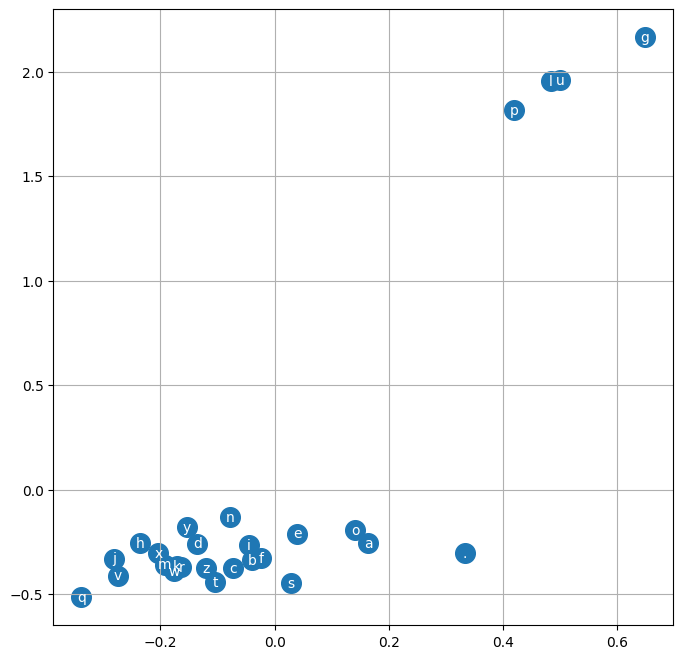

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

nri.
almyanleeelen.
hry.
lorenmrn.
rjd.
leo.
lie.
konelii.
nli.
relleie.
nean.
nar.
kalei.
hokalin.
shdhnrgshi.
jes.
kin.
renllionn.
coconuen.
ned.


In [ ]:
print(C.shape)
C[[0, 0, 0]]

torch.Size([27, 2])


tensor([[ 0.3326, -0.3022],
        [ 0.3326, -0.3022],
        [ 0.3326, -0.3022]], grad_fn=<IndexBackward0>)